In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
lam = np.hstack([-model_problem_spectrum(100,.9,1e2)[::-1],model_problem_spectrum(300,.8,1e3)])

In [4]:
q = 20
lmin = np.min(np.abs(lam))**2
lmax = np.max(np.abs(lam))**2

poles = np.zeros(q)
weights = np.zeros(q)

k2 = lmin/lmax
Kp = sp.special.ellipk(1-k2)

t = 1j*np.arange(1/2,q+1/2)*Kp/q

sn_,cn_,dn_,_ = sp.special.ellipj(np.imag(t),1-k2) # compute real valued functions to transform to what we need

cn = 1/cn_
dn = dn_ / cn_
sn = 1j * sn_ / cn_

poles = np.real(lmin * sn**2)

weights = (2 * Kp * np.sqrt(lmin))/(np.pi*q) * (cn * dn)

In [5]:
A_mat = lam

n = len(A_mat)
b_vec = np.ones(n,dtype=np.double)
b_vec /= np.linalg.norm(b_vec)

r = lambda x: np.sum( weights / (x[:,None]-poles) ,axis=1)
rAb = A_mat*r(A_mat**2)*b_vec
fAb = np.sign(A_mat)*b_vec

K = 550
K_ro = 120
Q,(a_,b_) = exact_lanczos(A_mat,b_vec,K,reorth=False)
Q_ro,(a_ro_,b_ro_) = exact_lanczos(A_mat,b_vec,K_ro,reorth=True)

error_OR = np.full(K,np.nan)
error_fOR = np.full(K,np.nan)
error_OR_ro = np.full(K,np.nan)
error_fOR_ro = np.full(K,np.nan)
for i in range(1,K):

    lank_OR = np.zeros(n)
    for l in range(q):
        lan_lm = streaming_banded_rational(n,i,(0,weights[l],0),(1,0,-poles[l]))
        for j in range(i):
            lan_lm.read_stream(Q[:,j],a_[j],b_[j])

        lan_lm.finish_up()      

        lank_OR += lan_lm()

    error_OR[i] = np.linalg.norm((rAb - lank_OR))
    error_fOR[i] = np.linalg.norm((fAb - lank_OR))
    
for i in range(1,K_ro):
    lank_OR_ro = np.zeros(n)
    for l in range(q):
        lan_lm = streaming_banded_rational(n,i,(0,weights[l],0),(1,0,-poles[l]))
        for j in range(i):
            lan_lm.read_stream(Q_ro[:,j],a_ro_[j],b_ro_[j])

        lan_lm.finish_up()      

        lank_OR_ro += lan_lm()

    error_OR_ro[i] = np.linalg.norm((rAb - lank_OR_ro))
    error_fOR_ro[i] = np.linalg.norm((fAb - lank_OR_ro))

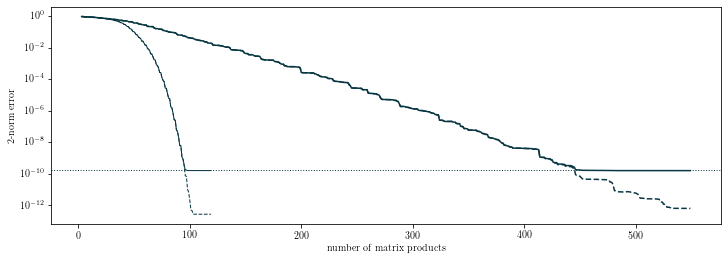

In [6]:
fig,axs = plt.subplots(1,1,figsize=(12,4),sharey='row',sharex=True)

#axs = axs.flatten()

fig.subplots_adjust(wspace=.05,hspace=.05)


axs.plot(error_OR/np.linalg.norm(b_vec),linestyle='--',color='#073642',label='lanczos-OR')
axs.plot(error_OR_ro/np.linalg.norm(b_vec),linestyle='--',lw=1,color='#073642',label='lanczos-OR')


axs.plot(error_fOR/np.linalg.norm(b_vec),linestyle='-',color='#073642',label='lanczos-OR')
axs.plot(error_fOR_ro/np.linalg.norm(b_vec),linestyle='-',lw=1,color='#073642',label='lanczos-OR')

axs.axhline(np.abs(1e3*r(np.array([1e3**2]))-1),linestyle=':',lw=1,color='#073642',)

axs.set_yscale('log')
axs.set_xlabel('number of matrix products')
axs.set_ylabel('$2$-norm error')

plt.savefig(f'imgs/Lanczos-OR-lm_delay.pdf',bbox_inches='tight')

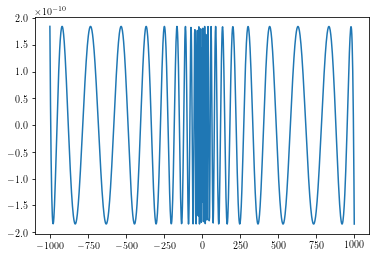

In [7]:
xx = np.linspace(-1e3,1e3,1000)
r = lambda x: np.sum( weights / (x[:,None]-poles) ,axis=1)

plt.plot(xx,xx*r(xx**2)-np.sign(xx))